In [1]:
import tensorflow as tf

# Importing matplotlib to plot images.
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Importing SK-learn to calculate precision and recall
import sklearn
import sklearn.metrics

# Used for graph export
from tensorflow.python.framework import graph_util
from tensorflow.python.framework import graph_io
from keras.models import load_model
from keras import backend as K

tf.__version__

Using TensorFlow backend.


'1.5.0'

In [2]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
# flatten image data <- NOT FOR CNN
#x_train = x_train.reshape(-1, 784)
#x_test = x_test.reshape(-1, 784)

# For CNNs  ->
###   DIFFERENT RESHAPE  ### 
### We here need the dimensions of the image plus a channel, e.g. for RGB images one have 3 channels ###
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# convert to float
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

# normalize to a scale between 0 and 1
x_train /= 255
x_test /= 255

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices (one-hot notation)
num_classes = 10
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes)

60000 train samples
10000 test samples


Text(0.5,1,'Label for image 31 is: 0')

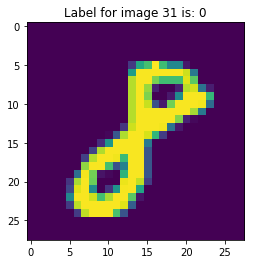

In [4]:
i = 31
plt.imshow(x_train[i].reshape(28, 28)) #np.sqrt(784) = 28
plt.title("Label for image %i is: %s" % (i, np.argmax(y_train[i])))

## GPU and CPU settings
If GPU is not available, comment out the bottom block.

In [5]:
# If GPU is not available: 
# GPU_USE = '/cpu:0'
# config = tf.ConfigProto(device_count = {"GPU": 0})


# If GPU is available: 
config = tf.ConfigProto()
config.log_device_placement = True
config.allow_soft_placement = True
config.gpu_options.allocator_type = 'BFC'

# Limit the maximum memory used
config.gpu_options.per_process_gpu_memory_fraction = 0.1

# set session config
tf.keras.backend.set_session(tf.Session(config=config))

In [13]:
########## HYPER PARAMETERS
batch_size = 128
epochs = 10
optimizer = tf.keras.optimizers.Adamax()
########## HYPER PARAMETERS

########## MODEL ARCHITECTURE
model = tf.keras.Sequential()

### OLD ARCHITECTURE START
#model.add(tf.keras.layers.Dense(5, activation='relu', input_shape=(784,)))
### OLD ARCHITECTURE END

### NEW CNN ARCHITECTURE
model.add(tf.keras.layers.Conv2D(5, kernel_size=(5, 5), activation='relu', input_shape=(28,28,1)))
model.add(tf.keras.layers.Flatten())
### NEW CNN ARCHITECTURE

model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
########## MODEL ARCHITECTURE

# Print summary
model.summary()

# compile model for training
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

history = model.fit(x_train, y_train_one_hot,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test_one_hot))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 24, 24, 5)         130       
_________________________________________________________________
flatten_3 (Flatten)          (None, 2880)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                28810     
Total params: 28,940
Trainable params: 28,940
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================]60000/60000 [==============================] - 4s 64us/step - loss: 0.4076 - acc: 0.8849 - val_loss: 0.2571 - val_acc: 0.9262

Epoch 2/10
60000/60000 [==============================]60000/60000 [==============================] - 4s 62us/step - loss: 0.2405 - acc: 0.9310 - val_loss: 0.2024 - val_a

# Plot training and test accuracy

In [14]:
# use model for inference to get test accuracy
y_test_pred = model.predict(x_test)
y_test_pred = np.argmax(y_test_pred, axis=1)

print ('\n Summary of the precision, recall, F1 score for each class:')
print (sklearn.metrics.classification_report(y_test, y_test_pred))

print ('\n Confusion matrix: ')
print (sklearn.metrics.confusion_matrix(y_test, y_test_pred))


 Summary of the precision, recall, F1 score for each class:
             precision    recall  f1-score   support

          0       0.97      0.99      0.98       980
          1       0.98      0.99      0.99      1135
          2       0.97      0.97      0.97      1032
          3       0.97      0.99      0.98      1010
          4       0.98      0.98      0.98       982
          5       0.98      0.97      0.98       892
          6       0.99      0.97      0.98       958
          7       0.98      0.96      0.97      1028
          8       0.96      0.96      0.96       974
          9       0.97      0.96      0.97      1009

avg / total       0.97      0.97      0.97     10000


 Confusion matrix: 
[[ 974    0    0    0    0    0    1    3    2    0]
 [   0 1123    4    2    0    1    1    0    4    0]
 [   3    4 1003    2    4    0    2    3    9    2]
 [   0    0    1 1002    0    4    0    0    2    1]
 [   1    0    3    0  961    0    2    1    3   11]
 [   3    2   

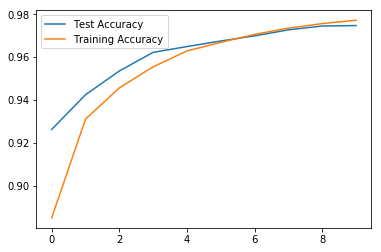

In [15]:
import matplotlib.pyplot as plt
plt.plot(history.history['val_acc'], label="Test Accuracy")
plt.plot(history.history['acc'], label="Training Accuracy")
plt.legend()

In [16]:
# save model
model.save("myModel.h5")